# Setup

In [3]:
import importlib
import os

import joblib
import pandas as pd

import tlp

url = 'https://snap.stanford.edu/data/soc-redditHyperlinks-body.tsv'
dataset_id = '28'
adjusted_intervals = dict()

# Download and extract data

In [32]:
os.makedirs(dataset_id, exist_ok=True)
edgelist_location = f'{dataset_id}/edgelist.pkl'
download_location = f'{dataset_id}/soc-redditHyperlinks-body.tsv'
if not os.path.isfile(edgelist_location):
  if not os.path.isfile(download_location):
    tlp.download_from_url(url, download_location)
    
  df = pd.read_csv(download_location, sep='\t', index_col=False, 
                   parse_dates=['TIMESTAMP'])
  df = df[df['LINK_SENTIMENT'] == 1]
  df = df.rename(
  columns={'SOURCE_SUBREDDIT': 'source', 'TARGET_SUBREDDIT': 'target', 
         'TIMESTAMP': 'datetime'})
  df[['source', 'target', 'datetime']].to_pickle(edgelist_location)

# Splitting

In [33]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist), **adjusted_intervals)
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 533 ms, sys: 7.15 ms, total: 540 ms
Wall time: 566 ms


# Instances

In [34]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

soc-redditHyperlinks-body.tsv:  13%|█▎        | 41.1M/319M [10:52<1:13:31, 63.0kB/s]


CPU times: user 45.9 s, sys: 1.26 s, total: 47.1 s
Wall time: 47 s


# Targets

In [35]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

Determine targets:   0%|          | 0/6890715 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 479 ms, total: 13.9 s
Wall time: 13.9 s


# Sampling

In [36]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 214 ms, sys: 93.1 ms, total: 307 ms
Wall time: 346 ms


# Features

## AA (time agnostic)

In [37]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 1.73 s, sys: 13.1 ms, total: 1.75 s
Wall time: 1.75 s


## AA (time aware)

In [38]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

time strategies:   0%|          | 0/3 [00:00<?, ?it/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

CPU times: user 59.2 s, sys: 749 ms, total: 60 s
Wall time: 59.5 s


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

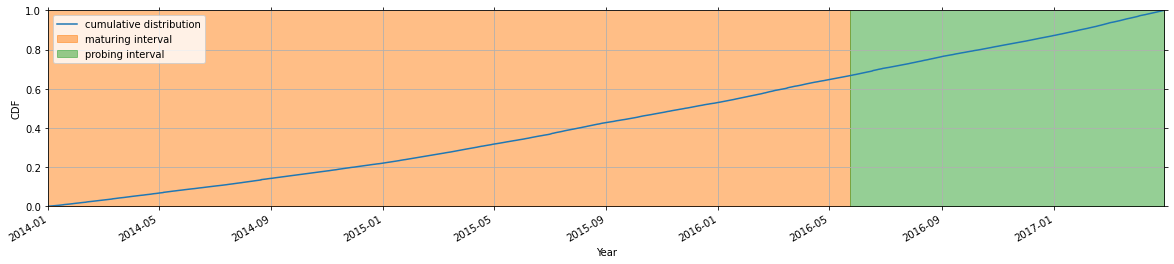

In [39]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'], **adjusted_intervals)

## Metric: Class imbalance

In [40]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,6882799,0.998851
True,7916,0.001149


## Figure: Datetime strategies

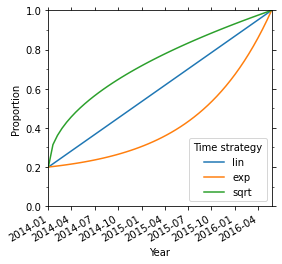

In [41]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

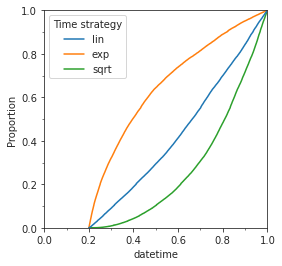

In [42]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

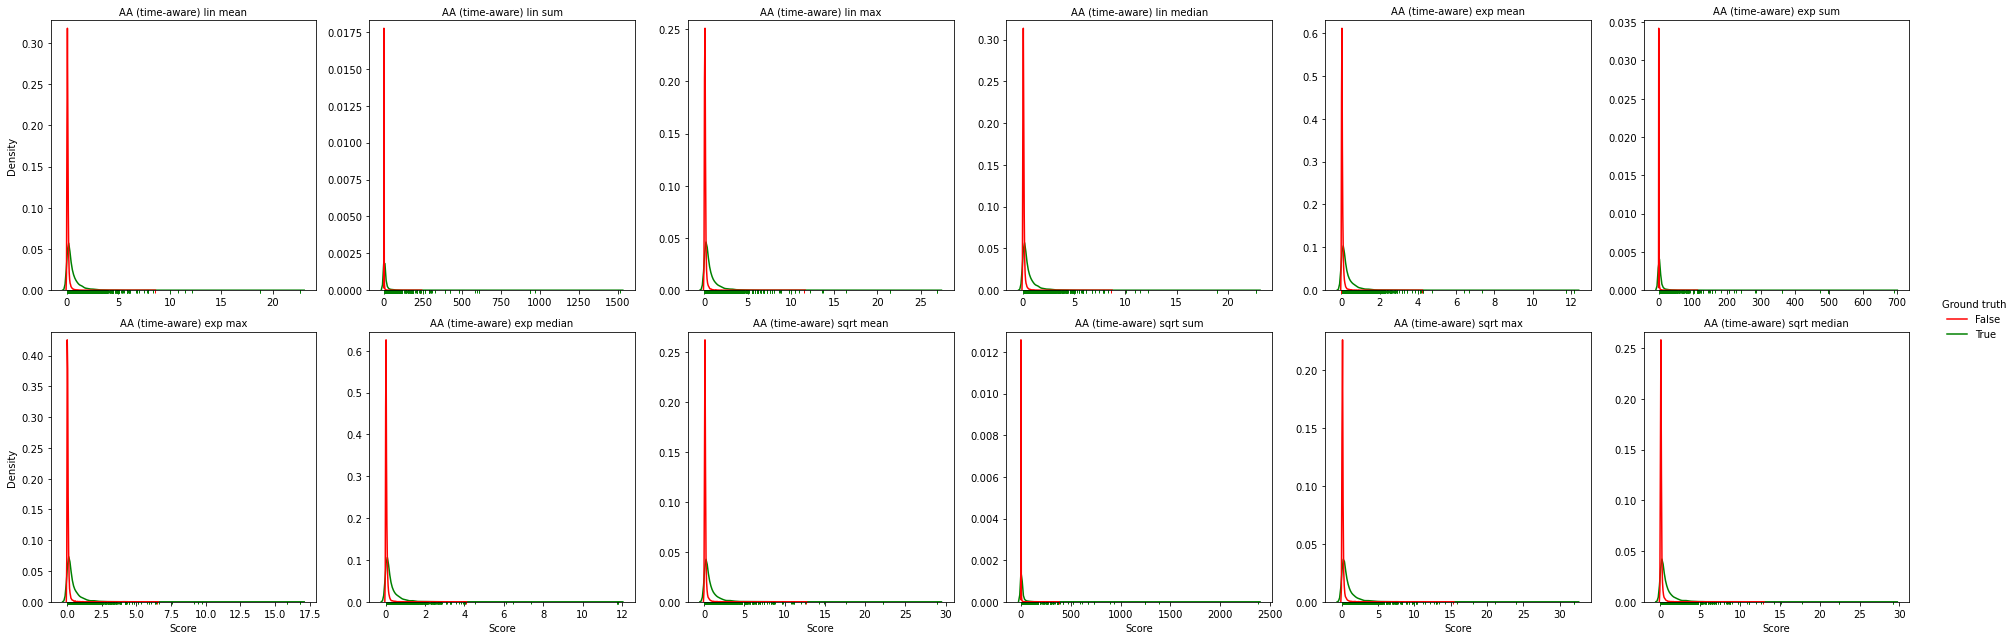

In [43]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

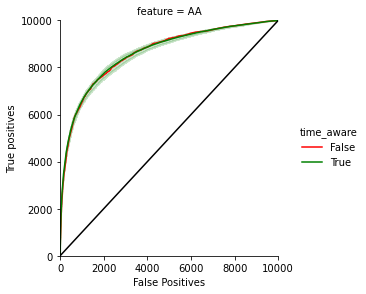

In [44]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [45]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)

feature  time_aware  aggregation_strategy  time_strategy
AA       False       NaN                   NaN              0.861707
         True        mean                  lin              0.856398
                     sum                   lin              0.867106
                     max                   lin              0.872569
                     median                lin              0.855418
                     mean                  exp              0.852051
                     sum                   exp              0.867360
                     max                   exp              0.870115
                     median                exp              0.845963
                     mean                  sqrt             0.862581
                     sum                   sqrt             0.866732
                     max                   sqrt             0.874422
                     median                sqrt             0.863496
Name: auc, dtype: float64